### **Configuração Inicial** 

In [ ]:
import sys

from google.colab import drive
drive.mount('/content/drive')

PATH = "drive/MyDrive/ML4AML"
sys.path.append(PATH)


Mounted at /content/drive


### **Carregando as bases de dados...**

In [ ]:
import pandas as pd

df_clinical_global = pd.read_csv(PATH+'/clinical_data/clinicaldata_merged_final.csv', sep=',', index_col=None) 
df_expressions_global = pd.read_csv(PATH+'/genetic_data/expressions/expressions_merged_intersection.csv', index_col=None) 

df_mutation_global = pd.read_csv(PATH+'/genetic_data/mutations/mutations_merged_intersection_final.csv', index_col=None) 

### **Funções de pré-processamento...**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

PATH = 'drive/MyDrive/ML4AML/'
KEY_MERGE = 'SAMPLE_ID'
CLASS_VARIABLE = "Overall Survival Status"
TREATMENT =  'Treatment Intensity'


def mergeDataSetsByKey(dataset1, dataset2, key):
    
    newDataSet = pd.merge(dataset1, dataset2, on=key)
    
    return newDataSet

def convertClassToNumber(df_dataset, class_label):
    label_encoder = LabelEncoder()
    # print(df_dataset[class_label])
    df_dataset[class_label] = label_encoder.fit_transform(df_dataset[class_label])

    return df_dataset

def normalizeData(df_dataset):

    column_list = ["Diagnosis Age", "Bone Marrow Blast Percentage", "Mutation Count", "PB Blast Percentage", "WBC"]

    for column in column_list:
        df_dataset[column] = zscore(df_dataset[column]) 
    return df_dataset

def preprocessingDataModel(df_dataset, to_drop=['Study ID', KEY_MERGE, 'Overall Survival (Months)']):
    df_dataset = df_dataset.drop(columns=to_drop)
    return pd.get_dummies(df_dataset)


def preprocess_validation(data):
        
    X_train_id = pd.read_csv(PATH+'merged_data/train_test_split/X_train_id.csv', sep=',', index_col=None) 
    X_valid_id = pd.read_csv(PATH+'merged_data/train_test_split/X_valid_id.csv', sep=',', index_col=None)
    
    X_full = pd.concat([X_train_id,X_valid_id])

    X_train = mergeDataSetsByKey(X_train_id, data, KEY_MERGE)
    X_valid = mergeDataSetsByKey(X_valid_id, data, KEY_MERGE)
    X_full = mergeDataSetsByKey(X_full, data, KEY_MERGE)

    y_train = X_train[CLASS_VARIABLE]
    y_valid = X_valid[CLASS_VARIABLE]
    y_full = X_full[CLASS_VARIABLE]

    X_train = X_train.drop(columns=[CLASS_VARIABLE, KEY_MERGE])
    X_valid = X_valid.drop(columns=[CLASS_VARIABLE, KEY_MERGE])
    X_full = X_full.drop(columns=[CLASS_VARIABLE, KEY_MERGE])
    
    return X_train, y_train, X_valid, y_valid, X_full, y_full

def preprocess_finaltest(data):
        
  X_id = pd.read_csv(PATH+'merged_data/train_test_split/X_final_test_id.csv', sep=',', index_col=None) 
    

  X = mergeDataSetsByKey(X_id, data, KEY_MERGE)
  y = X[CLASS_VARIABLE]
  X = X.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  return X, y



def preprocess(data_clin, data_mut=None, data_exp=None, features_mut=None, features_exp=None, to_merge="CLIN", drop_key=False, final=False):

  data = convertClassToNumber(data_clin, CLASS_VARIABLE)
  id_table = data[KEY_MERGE]

  if "CLIN" in to_merge:
    data = preprocessingDataModel(data)
    data = normalizeData(data)
    data.insert(0, KEY_MERGE, id_table)
  
  else:

    if "TREAT" in to_merge:

      data = data[[KEY_MERGE, TREATMENT, CLASS_VARIABLE]]    
      data = preprocessingDataModel(data, to_drop=[KEY_MERGE])
      data.insert(0, KEY_MERGE, id_table)
    
    else:
      data = data[[KEY_MERGE, CLASS_VARIABLE]]
 
    
    
  if "MUT" in to_merge:
    f_mut = features_mut.copy()
    f_mut.append(KEY_MERGE)
      
    df_to_append = data_mut[f_mut]
    different_columns = df_to_append.columns.difference(data.drop(columns=[KEY_MERGE]).columns)
    
    data = mergeDataSetsByKey(data, df_to_append[different_columns], KEY_MERGE)
  
  if "EXP" in to_merge:
    f_exp = features_exp.copy()
    f_exp.append(KEY_MERGE)
      
    df_to_append = data_exp[f_exp]
    different_columns = df_to_append.columns.difference(data.drop(columns=[KEY_MERGE]).columns)
    
    data = mergeDataSetsByKey(data, df_to_append[different_columns], KEY_MERGE)
  

  X_train_id = pd.read_csv(PATH+'merged_data/train_test_split/X_train_id.csv', sep=',', index_col=None) 
  X_valid_id = pd.read_csv(PATH+'merged_data/train_test_split/X_valid_id.csv', sep=',', index_col=None)
  X_test_id = pd.read_csv(PATH+'merged_data/train_test_split/X_test_id.csv', sep=',', index_col=None) 
  
  X_train_id = pd.concat([X_train_id, X_valid_id])
  
  X_id = pd.concat([X_train_id, X_test_id])
  
  if(final == True):
    X_train_id = pd.concat([X_train_id, X_test_id])
    X_test_id = pd.read_csv(PATH+'merged_data/train_test_split/X_final_test_id.csv', sep=',', index_col=None)
    X_id = pd.concat([X_id, X_test_id])

 

  X = mergeDataSetsByKey(X_id, data, KEY_MERGE)
  y = X[CLASS_VARIABLE]
  X = X.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  X_train = mergeDataSetsByKey(X_train_id, data, KEY_MERGE)
  X_test = mergeDataSetsByKey(X_test_id, data, KEY_MERGE)
  y_train = X_train[CLASS_VARIABLE]
  y_test = X_test[CLASS_VARIABLE]

  if drop_key:
    X_train = X_train.drop(columns=[CLASS_VARIABLE, KEY_MERGE])
  
  X_test = X_test.drop(columns=[CLASS_VARIABLE, KEY_MERGE])
  
  return X_train, y_train, X_test, y_test, [X,y]


# **Seleção de atributos - Mutação Gênica**

In [ ]:
#from data_preprocessing import preprocess

features_mut = df_mutation_global.columns
features_mut = features_mut.to_list()
features_mut.pop(0) #removendo SAMPLE ID


data_mut_train, y_train, data_mut_test, y_test, [X,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=None, features_mut=features_mut, features_exp=None, to_merge="MUT", drop_key=True)

In [ ]:
from sklearn.feature_selection import chi2

chi_scores = chi2(data_mut_train, y_train)
p_values = pd.Series(chi_scores[1],index = data_mut_train.columns)
p_values.sort_values(ascending = False , inplace = True)

alpha = 0.1
selected_mut_features = p_values.loc[lambda x: x < alpha]
selected_mut_features = list(selected_mut_features.index)
print(selected_mut_features)


['U2AF1', 'CADM2', 'CALR', 'CTNNA2', 'PRKAA2', 'RIF1', 'SRSF2', 'PTPN11', 'PHF6', 'TP53']


# **Seleção de atributos - Expressão Gênica**

In [ ]:

features_exp = df_expressions_global.columns
features_exp = features_exp.to_list()
features_exp.pop(0) #removendo SAMPLE ID


data_exp_train, y_train, data_exp_test, y_test, [X,y] = preprocess(df_clinical_global, data_mut=None, data_exp=df_expressions_global, features_mut=None, features_exp=features_exp, to_merge="EXP", drop_key=True)
features_exp = data_exp_train.columns


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


selected_exp_features = []

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=0)
lsvc.fit(data_exp_train, y_train)
selector = SelectFromModel(lsvc, prefit=True)

selected_exp_features = list(features_exp[selector.get_support()])

#index = 99
#for i in range(13):
#    print(index)
#    lsvc.fit(data_exp_train[0:index], y_train[0:index])
#    selector = SelectFromModel(lsvc, prefit=True)

#    #print(f"Features selected: {features_exp[selector.get_support()]}")
#    selected_features = list(features_exp[selector.get_support()])
#    #print(len(selected_features))
#    selected_exp_features.append(selected_features)
    
#    index += 10

#selected_exp_features = [item for sublist in selected_exp_features for item in sublist]
#selected_exp_features = pd.Series(selected_exp_features).value_counts()
#print(selected_exp_features)

#selected_exp_features = list(selected_exp_features[selected_exp_features.values > 5].index)

print(selected_exp_features)

['CCDC144A', 'CPNE8', 'CYP2E1', 'CYTL1', 'HAS1', 'KIAA0141', 'KIAA1549', 'LAMA2', 'LTK', 'MICALL2', 'MX1', 'PPM1H', 'PTH2R', 'PTP4A3', 'RAD21', 'RGS9BP', 'SLC29A2', 'TMED4', 'TNFSF11', 'TNK1', 'TSKS', 'XIST']


# **Treinamento dos Modelos**

In [ ]:
literature_features = ['FLT3', 'NPM1', 'DNMT3A', 'IDH1', 'IDH2', 'TP53', 'TET2', 'ASXL1', 'RUNX1', 'CEBPA', 'NRAS', 'KRAS', 'SF3B1', 'U2AF1', 'SRSF2']

#selected_mut_features = list(set(selected_mut_features + literature_features))

#selected_exp_features = list(set(selected_exp_features + literature_features))

print(selected_mut_features)
print(selected_exp_features)

['U2AF1', 'CADM2', 'CALR', 'CTNNA2', 'PRKAA2', 'RIF1', 'SRSF2', 'PTPN11', 'PHF6', 'TP53']
['CCDC144A', 'CPNE8', 'CYP2E1', 'CYTL1', 'HAS1', 'KIAA0141', 'KIAA1549', 'LAMA2', 'LTK', 'MICALL2', 'MX1', 'PPM1H', 'PTH2R', 'PTP4A3', 'RAD21', 'RGS9BP', 'SLC29A2', 'TMED4', 'TNFSF11', 'TNK1', 'TSKS', 'XIST']


### Funções Auxiliares...

In [ ]:
import seaborn as sns
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


def conf_matrix(y_test, y_pred):

    total_cm = metrics.confusion_matrix(y_test, y_pred)

    group_counts = ["{0:0.0f}".format(value) for value in total_cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in total_cm.flatten()/np.sum(total_cm)]
    labels = [f"{v1}\n{v2}" for v1,v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(total_cm, annot=labels, fmt="", annot_kws={"size":20})

    #ax = sns.heatmap(total_cm, annot=True, annot_kws={"size":20})
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    #plt.title("Ensemble | Holdout")
    #plt.savefig("confusion_matrix_holdout.png")
    plt.show()


def checkPerformance(y_test, y_pred, verbose=True):

    f1_result = metrics.f1_score(y_test, y_pred, average="weighted", zero_division=1)
    pres = metrics.precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=1)
    acc = metrics.accuracy_score(y_test, y_pred)
    
    
    try:
        roc = metrics.roc_auc_score(y_test, y_pred)
    except ValueError:
        roc = 0
    
    if (verbose == True): 
      print("F1: %.4f%%" % (f1_result))
      print("Precision: %.4f%%" % (pres))
      print("Recall: %.4f%%" % (recall))
      print("Accuracy: %.4f%%" % (acc))
      print("\nAUC: %.4f%%" % (roc))

    return f1_result, pres, recall, acc, roc

def randomForestModel(X_train, y_train, X_test, y_test, name):
    
    
    X_train_i, y_train_i, X_val, y_val, X_train, y_train = preprocess_validation(X_train)


    grid = { 
        'random_state' : [1],
        #'probability': [True]
        
        "n_estimators":[25, 30, 50, 75, 100],
        #"n_estimators":[24, 36, 48, 72],
        'min_samples_leaf':[3,4,5],
        #'max_depth':[8, 10, 15, 20],#10, 12, 20, 25, None],
        'max_depth':[8,10,12,14],
        'class_weight':['balanced']
    }

    cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv=5)
    cv.fit(X_train_i, y_train_i)

   
    rf = RandomForestClassifier(**cv.best_params_)#, class_weight='balanced', random_state=42)
    
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)

    y_pred = rf.predict(X_test)

    y_probs = rf.predict_proba(X_test)[:,1]
    
   
    
    #print("Training Performance")
    #a, b, c, d, e = checkPerformance(y_train, y_pred_train)
    
    print("Test Performance")
    f1_result, pres, recall, acc, roc = checkPerformance(y_test, y_pred)


    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc, 
    "Precision":pres, 
    "Recall":recall, 
    }
    results = pd.DataFrame(data=[results])

    conf_matrix(y_test, y_pred)
    
    return y_pred, y_probs, results, rf


def svmModel(X_train, y_train, X_test, y_test, name):
    
    X_train_i, y_train_i, X_val, y_val, X_train, y_train = preprocess_validation(X_train)
    

    grid = { 
        'class_weight': ['balanced'],
        'kernel':['linear'], 
        #'C':[0.05, 0.01, 0.001],
        #'C':[0.001, 0.0001, 0.00001], 
        'C': [0.00005, 0.00001, 0.000001], 
        'random_state' : [1],
        'probability': [True]
    }

    cv = GridSearchCV(estimator=svm.SVC(), param_grid=grid, cv=5)
    cv.fit(X_train_i, y_train_i)

    #Create a svm Classifier
    #clf = svm.SVC(kernel='linear', probability=True)#, class_weight='balanced', random_state=42)
    clf = svm.SVC(**cv.best_params_)
    

    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    
    y_pred = clf.predict(X_test)

    y_probs = []
    #y_probs = clf.predict_proba(X_test)[:,1]

    #print("Training Performance")
    #a, b, c, d, e = checkPerformance(y_train, y_pred_train)
    
    print("Test Performance")
    f1_result, pres, recall, acc, roc = checkPerformance(y_test, y_pred)
    
    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc, 
    "Precision":pres, 
    "Recall":recall, 
    }
    results = pd.DataFrame(data=[results])


    conf_matrix(y_test, y_pred)
    return y_pred, y_probs, results, clf
    
def logisticRegressionModel(X_train, y_train, X_test, y_test, name):

    X_train_i, y_train_i, X_val, y_val, X_train, y_train = preprocess_validation(X_train)


    grid = { 
        'class_weight': ['balanced'],
        'C':[0.00005, 0.00001, 0.000001],
        #'C': [0.1, 0.5, 0.01, 0.05],     
        #'C': [5, 2.5, 1.5, 1], 
    
        'penalty':["l2"],
        'random_state' : [1]
    }

    cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, cv=5)
    cv.fit(X_train_i, y_train_i)


    
    clf = LogisticRegression(**cv.best_params_)

    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    
    y_pred = clf.predict(X_test)

    y_probs = clf.predict_proba(X_test)[:,1]
   
    #print("Training Performance")
    #a, b, c, d, e = checkPerformance(y_train, y_pred_train)
    
    print("Test Performance")
    f1_result, pres, recall, acc, roc = checkPerformance(y_test, y_pred)

   
    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc, 
    "Precision":pres, 
    "Recall":recall, 
    }

    results = pd.DataFrame(data=[results])


    conf_matrix(y_test, y_pred)
    return y_pred, y_probs, results, clf


def findBestModel(model_rf,rf_results, model_lr,lr_results, model_svm, svm_results, metric):

   
    if( (rf_results[metric] >= lr_results[metric]).any() and (rf_results[metric] >= svm_results[metric]).any() ):
        return model_rf, rf_results
    elif( (lr_results[metric] > rf_results[metric]).any() and (lr_results[metric] > svm_results[metric]).any() ):
        return model_lr, lr_results
    else:
        return model_svm, svm_results

    

### **Dados Clínicos**


Clinical Data


Random Forest
Test Performance
F1: 0.6714%
Precision: 0.6853%
Recall: 0.6667%
Accuracy: 0.6667%

AUC: 0.6667%


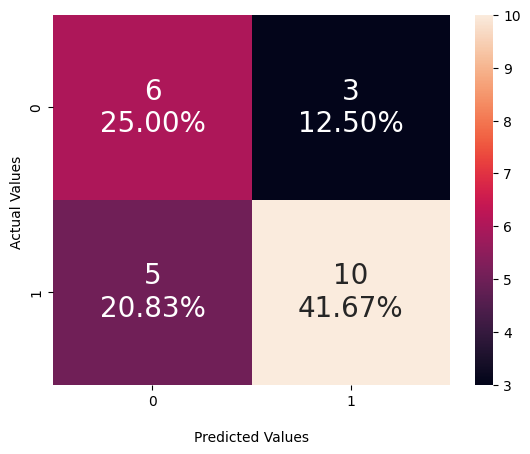

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=30, random_state=1)


SVM
Test Performance
F1: 0.4808%
Precision: 0.7656%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.5000%


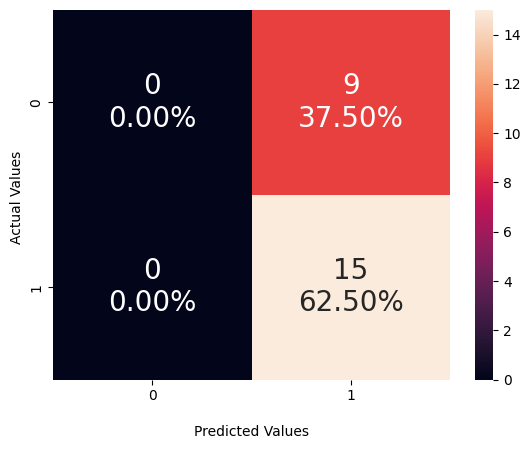

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.6713%
Precision: 0.7133%
Recall: 0.6667%
Accuracy: 0.6667%

AUC: 0.6889%


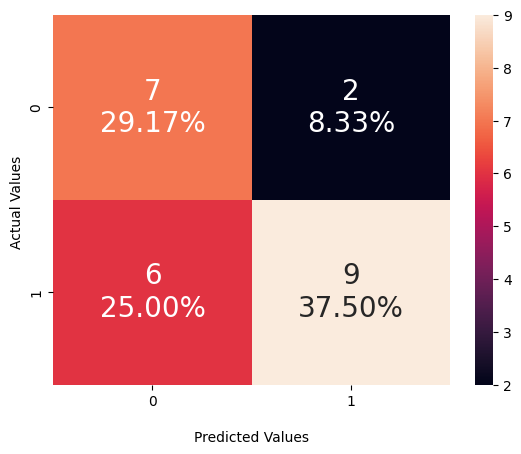

LogisticRegression(C=5e-05, class_weight='balanced', random_state=1)


In [ ]:

randomforest_df = pd.DataFrame()
logisticreg_df = pd.DataFrame()
svm_df = pd.DataFrame()

# clinical data model
print("\nClinical Data")

data_clin_train, y_train, data_clin_test, y_test, [data_clin, y_clin] =  preprocess(df_clinical_global, data_mut=None, data_exp=None, features_mut=None, features_exp=None, to_merge="CLIN", drop_key=False, final=False)
print("\n\nRandom Forest")
pred, prob, results_rf, clin_rf = randomForestModel(data_clin_train, y_train, data_clin_test, y_test, "CLIN")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(clin_rf)

print("\n\nSVM")
pred, prob, results_svm, clin_svm = svmModel(data_clin_train,y_train,data_clin_test, y_test,"CLIN")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(clin_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, clin_lr = logisticRegressionModel(data_clin_train,y_train,data_clin_test, y_test, "CLIN")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(clin_lr)


best_clin, best_clin_results = findBestModel(clin_rf, results_rf,clin_lr, results_lr,clin_svm, results_svm, 'F1-Score')


### **Dados de Mutação**


Mutation Data


Random Forest
Test Performance
F1: 0.7130%
Precision: 0.7396%
Recall: 0.7083%
Accuracy: 0.7083%

AUC: 0.7222%


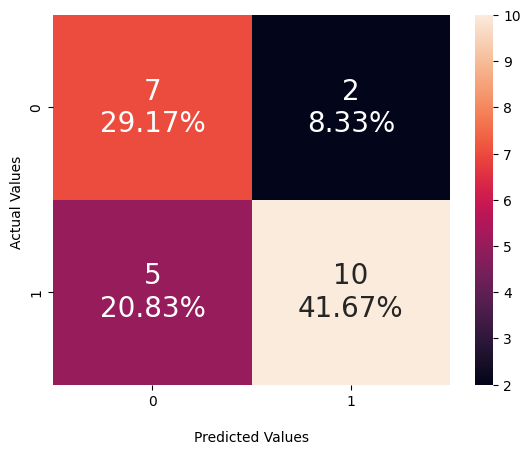

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=50, random_state=1)


SVM
Test Performance
F1: 0.4808%
Precision: 0.7656%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.5000%


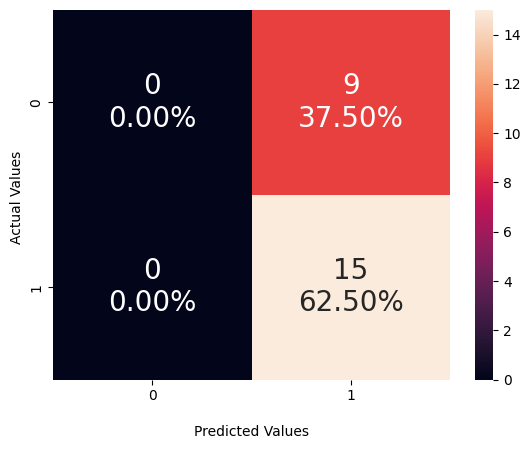

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.6714%
Precision: 0.6853%
Recall: 0.6667%
Accuracy: 0.6667%

AUC: 0.6667%


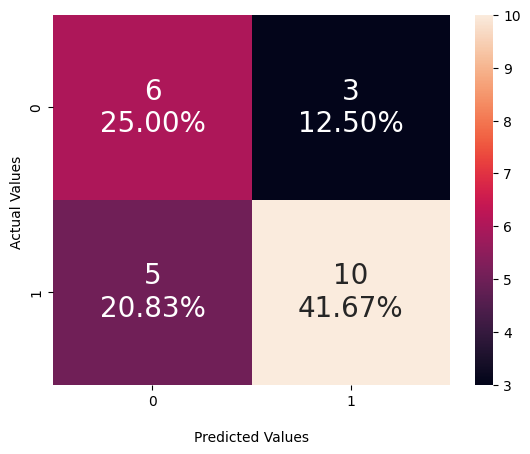

LogisticRegression(C=5e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nMutation Data")
data_mut_train, y_train, data_mut_test, y_test, [data_mut,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=None, features_mut=selected_mut_features, features_exp=None, to_merge=["MUT", "TREAT"], drop_key=False,  final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, mut_rf = randomForestModel(data_mut_train, y_train, data_mut_test, y_test, "MUT")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(mut_rf)

print("\n\nSVM")
pred, prob, results_svm, mut_svm = svmModel(data_mut_train, y_train, data_mut_test, y_test, "MUT")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(mut_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, mut_lr = logisticRegressionModel(data_mut_train, y_train, data_mut_test, y_test, "MUT")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(mut_lr)

best_mut, best_mut_results = findBestModel(mut_rf, results_rf,mut_lr, results_lr,mut_svm, results_svm, 'F1-Score')


### **Dados de Expressão**


Expression Data


Random Forest
Test Performance
F1: 0.6924%
Precision: 0.7014%
Recall: 0.7083%
Accuracy: 0.7083%

AUC: 0.6556%


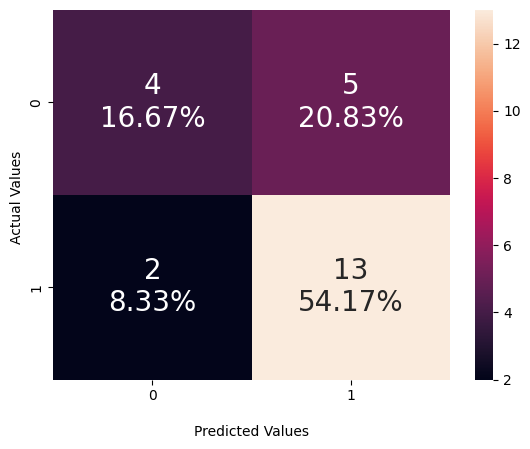

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=50, random_state=1)


SVM
Test Performance
F1: 0.2045%
Precision: 0.7656%
Recall: 0.3750%
Accuracy: 0.3750%

AUC: 0.5000%


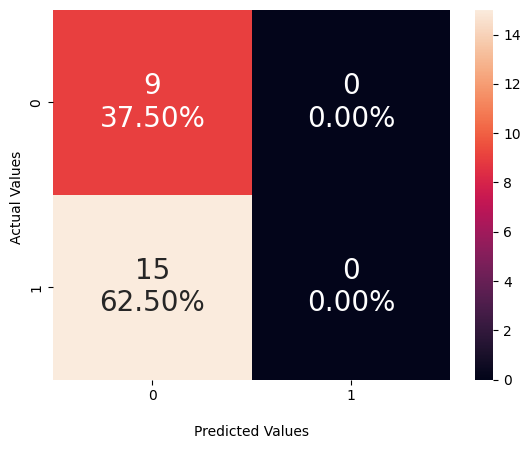

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.5893%
Precision: 0.6031%
Recall: 0.5833%
Accuracy: 0.5833%

AUC: 0.5778%


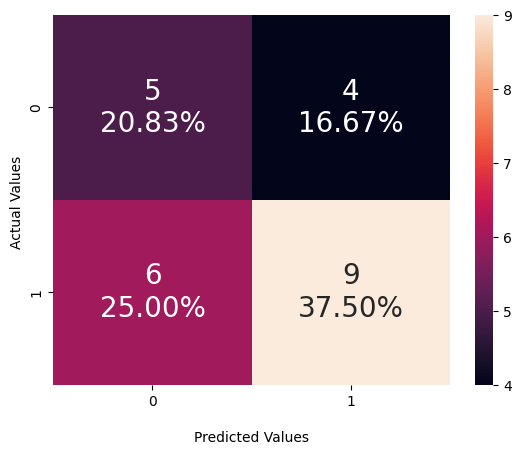

LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nExpression Data")
data_exp_train, y_train, data_exp_test, y_test, [data_exp,y] = preprocess(df_clinical_global, data_mut=None, data_exp=df_expressions_global, features_mut=None, features_exp=selected_exp_features, to_merge=["EXP", "TREAT"], drop_key=False, final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, exp_rf = randomForestModel(data_exp_train, y_train, data_exp_test, y_test, "EXP")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(exp_rf)

print("\n\nSVM")
pred, prob, results_svm, exp_svm = svmModel(data_exp_train, y_train, data_exp_test, y_test, "EXP")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(exp_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, exp_lr = logisticRegressionModel(data_exp_train, y_train, data_exp_test, y_test, "EXP")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(exp_lr)

best_exp, best_exp_results = findBestModel(exp_rf, results_rf, exp_lr, results_lr, exp_svm, results_svm, 'F1-Score')


### **Dados Clínicos + Mutação**


Clinical + Mutation Data


Random Forest
Test Performance
F1: 0.6667%
Precision: 0.6667%
Recall: 0.6667%
Accuracy: 0.6667%

AUC: 0.6444%


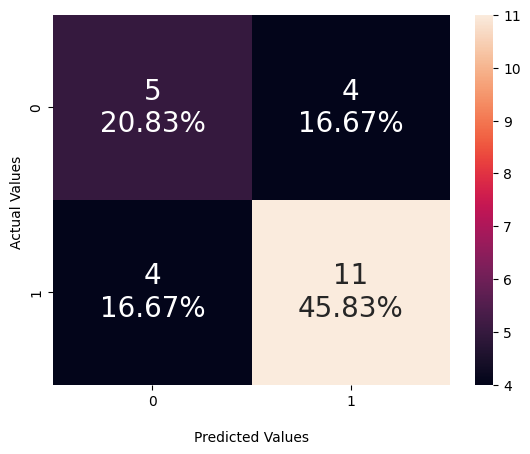

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=3, n_estimators=25, random_state=1)


SVM
Test Performance
F1: 0.4808%
Precision: 0.7656%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.5000%


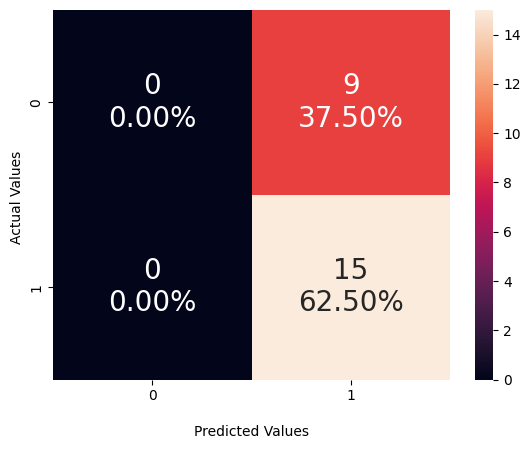

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.6924%
Precision: 0.7014%
Recall: 0.7083%
Accuracy: 0.7083%

AUC: 0.6556%


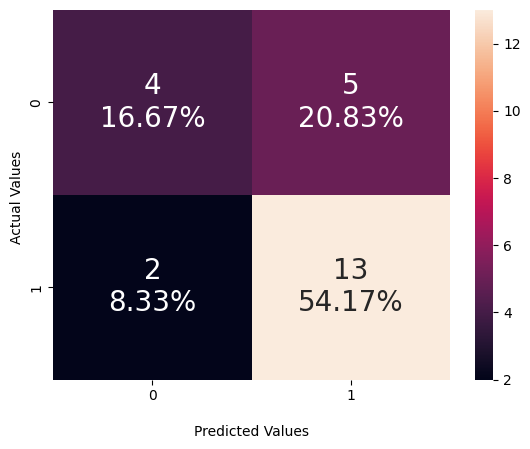

LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nClinical + Mutation Data")
data_clinmut_train, y_train, data_clinmut_test, y_test, [data_clinmut,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=None, features_mut=selected_mut_features, features_exp=None, to_merge=["MUT", "CLIN"], drop_key=False, final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, clinmut_rf = randomForestModel(data_clinmut_train, y_train, data_clinmut_test, y_test, "CLIN+MUT")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(clinmut_rf)

print("\n\nSVM")
pred, prob, results_svm, clinmut_svm = svmModel(data_clinmut_train, y_train, data_clinmut_test, y_test, "CLIN+MUT")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(clinmut_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, clinmut_lr = logisticRegressionModel(data_clinmut_train, y_train, data_clinmut_test, y_test, "CLIN+MUT")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(clinmut_lr)

best_clinmut, best_clinmut_results = findBestModel(clinmut_rf, results_rf, clinmut_lr, results_lr, clinmut_svm, results_svm, 'F1-Score')


### **Dados Clínicos + Expressão**


Clinical + Expression Data


Random Forest
Test Performance
F1: 0.6563%
Precision: 0.6555%
Recall: 0.6667%
Accuracy: 0.6667%

AUC: 0.6222%


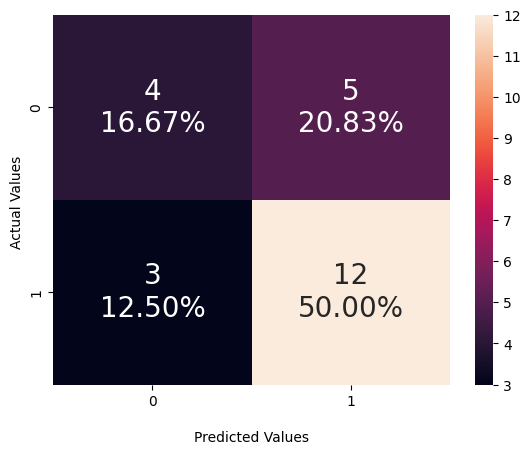

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=30, random_state=1)


SVM
Test Performance
F1: 0.2045%
Precision: 0.7656%
Recall: 0.3750%
Accuracy: 0.3750%

AUC: 0.5000%


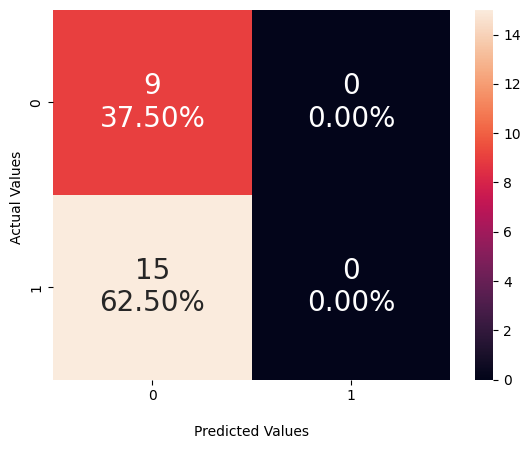

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.6284%
Precision: 0.6339%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.6111%


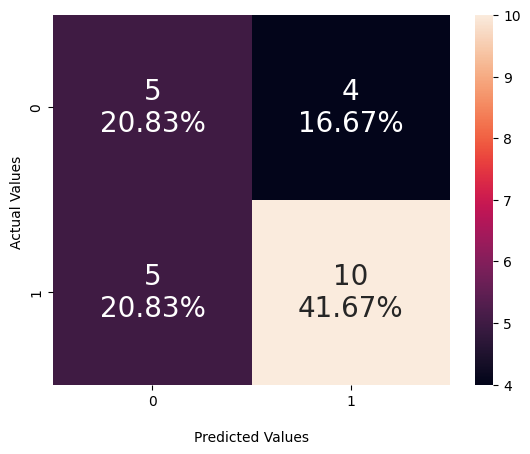

LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nClinical + Expression Data")
data_clinexp_train, y_train, data_clinexp_test, y_test, [data_clinexp,y] = preprocess(df_clinical_global, data_mut=None, data_exp=df_expressions_global, features_mut=None, features_exp=selected_exp_features, to_merge=["EXP", "CLIN"], drop_key=False, final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, clinexp_rf = randomForestModel(data_clinexp_train, y_train, data_clinexp_test, y_test, "CLIN+EXP")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(clinexp_rf)

print("\n\nSVM")
pred, prob, results_svm, clinexp_svm = svmModel(data_clinexp_train, y_train, data_clinexp_test, y_test, "CLIN+EXP")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(clinexp_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, clinexp_lr = logisticRegressionModel(data_clinexp_train, y_train, data_clinexp_test, y_test, "CLIN+EXP")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(clinexp_lr)

best_clinexp, best_clinexp_results = findBestModel(clinexp_rf, results_rf, clinexp_lr, results_lr, clinexp_svm, results_svm, 'F1-Score')


### **Dados Mutação + Expressão**


Mutation + Expression Data


Random Forest
Test Performance
F1: 0.6045%
Precision: 0.6042%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.5667%


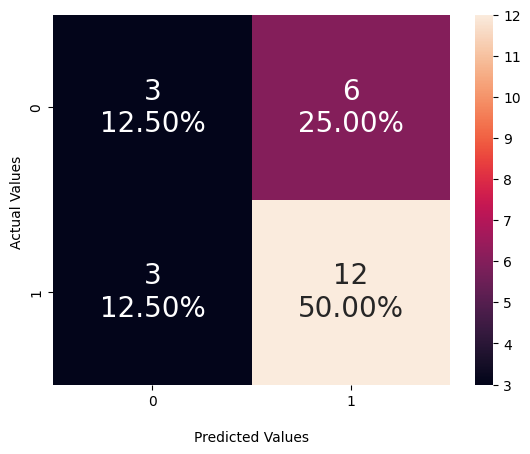

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=5,
                       random_state=1)


SVM
Test Performance
F1: 0.2045%
Precision: 0.7656%
Recall: 0.3750%
Accuracy: 0.3750%

AUC: 0.5000%


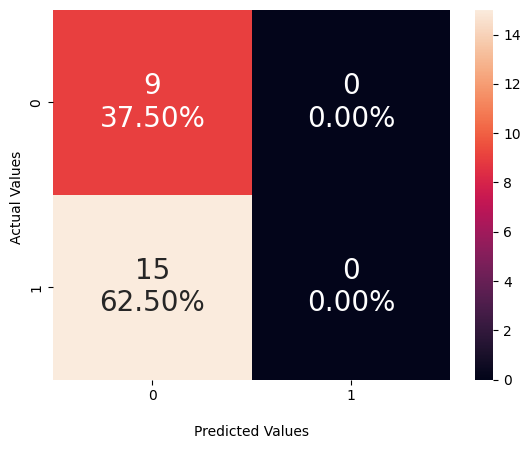

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.5893%
Precision: 0.6031%
Recall: 0.5833%
Accuracy: 0.5833%

AUC: 0.5778%


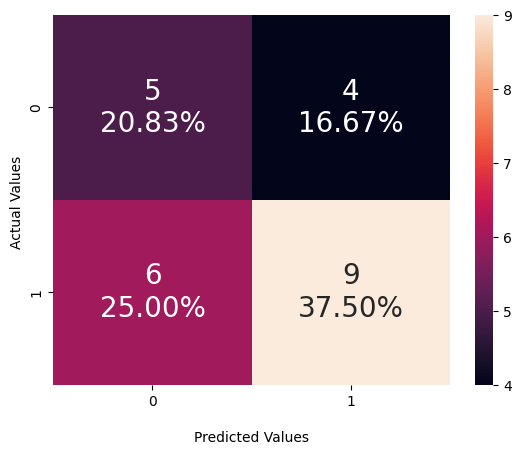

LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nMutation + Expression Data")
data_mutexp_train, y_train, data_mutexp_test, y_test, [data_mutexp,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=df_expressions_global, features_mut=selected_mut_features, features_exp=selected_exp_features, to_merge=["MUT", "EXP","TREAT"], drop_key=False, final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, mutexp_rf = randomForestModel(data_mutexp_train, y_train, data_mutexp_test, y_test, "MUT+EXP")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(mutexp_rf)

print("\n\nSVM")
pred, prob, results_svm, mutexp_svm = svmModel(data_mutexp_train, y_train, data_mutexp_test, y_test, "MUT+EXP")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(mutexp_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, mutexp_lr = logisticRegressionModel(data_mutexp_train, y_train, data_mutexp_test, y_test, "MUT+EXP")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(mutexp_lr)

best_mutexp, best_mutexp_results = findBestModel(mutexp_rf, results_rf, mutexp_lr, results_lr, mutexp_svm, results_svm, 'F1-Score')


### **Dados Clínicos + Mutação + Expressão**


Clinical + Mutation + Expression Data


Random Forest
Test Performance
F1: 0.6045%
Precision: 0.6042%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.5667%


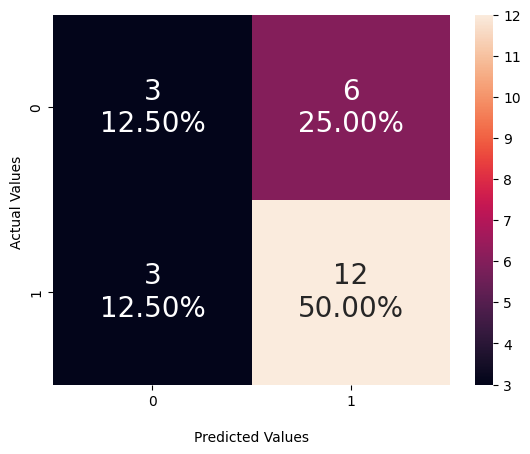

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       random_state=1)


SVM
Test Performance
F1: 0.2045%
Precision: 0.7656%
Recall: 0.3750%
Accuracy: 0.3750%

AUC: 0.5000%


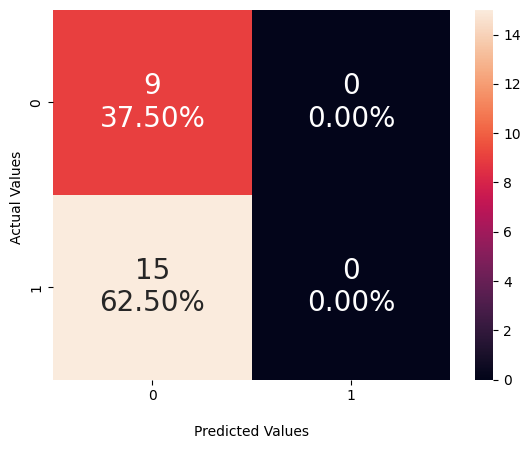

SVC(C=5e-05, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)


Logistic Regression
Test Performance
F1: 0.6284%
Precision: 0.6339%
Recall: 0.6250%
Accuracy: 0.6250%

AUC: 0.6111%


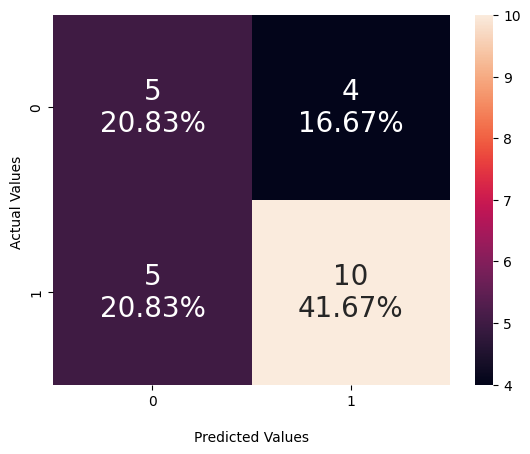

LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)


In [ ]:

print("\nClinical + Mutation + Expression Data")
data_all_train, y_train, data_all_test, y_test, [data_all,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=df_expressions_global, features_mut=selected_mut_features, features_exp=selected_exp_features, to_merge=["MUT", "EXP", "CLIN"], drop_key=False, final=False)

print("\n\nRandom Forest")
pred, prob, results_rf, all_rf = randomForestModel(data_all_train, y_train, data_all_test, y_test, "CLIN+MUT+EXP")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(all_rf)

print("\n\nSVM")
pred, prob, results_svm, all_svm = svmModel(data_all_train, y_train, data_all_test, y_test, "CLIN+MUT+EXP")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(all_svm)

print("\n\nLogistic Regression")
pred, prob, results_lr, all_lr = logisticRegressionModel(data_all_train, y_train, data_all_test, y_test, "CLIN+MUT+EXP")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(all_lr)

best_all, best_all_results = findBestModel(all_rf, results_rf, all_lr, results_lr, all_svm, results_svm, 'F1-Score')


### **Salvando resultados...**

In [ ]:
randomforest_df.to_csv(PATH+"randomforest_results.csv", index=False)
svm_df.to_csv(PATH+"svm_results.csv", index=False)
logisticreg_df.to_csv(PATH+"logisticreg_results.csv", index=False)

# **Ensemble Holdout**

### **Funções auxiliares...**

In [ ]:
from sklearn.utils.extmath import weighted_mode
from statistics import mode

def write_results(lines, file, m):
    with open(PATH+file, m) as file:
        for l in lines:
            file.write(l)
        file.close()

#ensemble holdout 3 bases
def ensembleModelHoldout(preditions, probs, weights, y_test, title, useavg=False):
    ensemble_pred = []
    #ensemble_probs = []
    if useavg == True:
        
        for i in range(len(preditions)):  
            #print(weights)
                      
            ensemble_pred.append(weighted_mode(preditions[i], weights)[0])
                          
            #ensemble_probs.append(mean(probs[i]))
    else:
            
        #return
        for i in range(len(preditions)):                    
            ensemble_pred.append(mode(preditions[i]))
            #ensemble_probs.append(mean(probs[i]))
        
    #treinar modelos com as bases de treino
    #-log2(1-0.3)
    #acumular resultados dos testes para gerar o modelo?

    f1_result = metrics.f1_score(ensemble_pred, y_test, average="weighted", zero_division=1)
    pres = metrics.precision_score(ensemble_pred, y_test, average="weighted", zero_division=1)
    recall = metrics.recall_score(ensemble_pred, y_test, average='weighted', zero_division=1)
    acc = metrics.accuracy_score(ensemble_pred, y_test)

    print("F1: %.4f%%" % (f1_result))
    print("Precision: %.4f%%" % (pres))
    print("Recall: %.4f%%" % (recall))
    print("Accuracy: %.4f%%" % (acc))
    
    try:

        roc = metrics.roc_auc_score(ensemble_pred, y_test)
    except ValueError:
        roc = 0
    print("\nAUC: %.4f%%" % (roc))
    

    write_results(title, "ensemble_holdout_results.txt", "a")

    lines = ["\n\n------- Ensemble -------\n"
    "F1: "+str(f1_result)+"\n"
    "Precision: "+str(pres)+"\n"
    "Recall: "+str(recall)+"\n"
    "AUC: "+str(roc)+"\n"
    "Accuracy: "+str(acc)+"\n"
    ]

    write_results(lines, "ensemble_holdout_results.txt", "a")
    
    conf_matrix(ensemble_pred, y_test)
    return ensemble_pred

### **Preparando os dados...**

In [ ]:
data_clin_train, y_train, data_clin_final, y_final, [data_clin, y_clin] =  preprocess(df_clinical_global, data_mut=None, data_exp=None, features_mut=None, features_exp=None, to_merge="CLIN", drop_key=True, final=True)
data_mut_train, y_train, data_mut_final, y_final, [data_mut,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=None, features_mut=selected_mut_features, features_exp=None, to_merge=["MUT", "TREAT"], drop_key=True,  final=True)
data_exp_train, y_train, data_exp_final, y_final, [data_exp,y] = preprocess(df_clinical_global, data_mut=None, data_exp=df_expressions_global, features_mut=None, features_exp=selected_exp_features, to_merge=["EXP", "TREAT"], drop_key=True, final=True)
data_clinmut_train, y_train, data_clinmut_final, y_final, [data_clinmut,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=None, features_mut=selected_mut_features, features_exp=None, to_merge=["MUT", "CLIN"], drop_key=True, final=True)
data_clinexp_train, y_train, data_clinexp_final, y_final, [data_clinexp,y] = preprocess(df_clinical_global, data_mut=None, data_exp=df_expressions_global, features_mut=None, features_exp=selected_exp_features, to_merge=["EXP", "CLIN"], drop_key=True, final=True)
data_mutexp_train, y_train, data_mutexp_final, y_final, [data_mutexp,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=df_expressions_global, features_mut=selected_mut_features, features_exp=selected_exp_features, to_merge=["MUT", "EXP","TREAT"], drop_key=True, final=True)
data_all_train, y_train, data_all_final, y_final, [data_all,y] = preprocess(df_clinical_global, data_mut=df_mutation_global, data_exp=df_expressions_global, features_mut=selected_mut_features, features_exp=selected_exp_features, to_merge=["MUT", "EXP", "CLIN"], drop_key=True, final=True)


### **Construindo o ensemble com os melhores modelos individuais...**

In [ ]:
#vetor de pesos com as f-medidas resultantes do treinamento dos melhores modelos
weights = [best_clin_results['F1-Score'][0], best_mut_results['F1-Score'][0], best_clinmut_results['F1-Score'][0], best_exp_results['F1-Score'][0], best_clinexp_results['F1-Score'][0], best_mutexp_results['F1-Score'][0], best_all_results['F1-Score'][0]]
weights = np.array(weights)
weighted_rank = (np.log2(1/weights))


#treinamento de modelos e predição da partição de teste final
best_clin.fit(data_clin_train, y_train)
clin_pred = best_clin.predict(data_clin_final)
clin_prob = best_clin.predict_proba(data_clin_final)
checkPerformance(clin_pred, y_final)
print(best_clin)

best_mut.fit(data_mut_train, y_train)
mut_pred = best_mut.predict(data_mut_final)
mut_prob = best_mut.predict_proba(data_mut_final)
checkPerformance(mut_pred, y_final)
print(best_mut)


best_clinmut.fit(data_clinmut_train, y_train)
clinmut_pred = best_clinmut.predict(data_clinmut_final)
clinmut_prob = best_clinmut.predict_proba(data_clinmut_final)
checkPerformance(clinmut_pred, y_final)
print(best_clinmut)

best_exp.fit(data_exp_train, y_train)
exp_pred = best_exp.predict(data_exp_final)
exp_prob = best_exp.predict_proba(data_exp_final)
checkPerformance(exp_pred, y_final)
print(best_exp)

best_clinexp.fit(data_clinexp_train, y_train)
clinexp_pred = best_clinexp.predict(data_clinexp_final)
clinexp_prob = best_clinexp.predict_proba(data_clinexp_final)
checkPerformance(clinexp_pred, y_final)
print(best_clinexp)

best_mutexp.fit(data_mutexp_train, y_train)
mutexp_pred = best_mutexp.predict(data_mutexp_final)
mutexp_prob = best_mutexp.predict_proba(data_mutexp_final)
checkPerformance(mutexp_pred, y_final)
print(best_mutexp)

best_all.fit(data_all_train,y_train)
all_pred = best_all.predict(data_all_final)
all_prob = best_all.predict_proba(data_all_final)
checkPerformance(all_pred, y_final)
print(best_all)

F1: 0.5824%
Precision: 0.7540%
Recall: 0.5714%
Accuracy: 0.5714%

AUC: 0.6625%
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=30, random_state=1)
F1: 0.6429%
Precision: 0.7571%
Recall: 0.6429%
Accuracy: 0.6429%

AUC: 0.7000%
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=50, random_state=1)
F1: 0.6946%
Precision: 0.7250%
Recall: 0.6786%
Accuracy: 0.6786%

AUC: 0.6429%
LogisticRegression(C=1e-05, class_weight='balanced', random_state=1)
F1: 0.7476%
Precision: 0.7472%
Recall: 0.7500%
Accuracy: 0.7500%

AUC: 0.7299%
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=50, random_state=1)
F1: 0.7624%
Precision: 0.7917%
Recall: 0.7500%
Accuracy: 0.7500%

AUC: 0.7381%
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=30, ra

ENSEMBLE - ALL MODELS
F1: 0.7476%
Precision: 0.7472%
Recall: 0.7500%
Accuracy: 0.7500%

AUC: 0.7299%


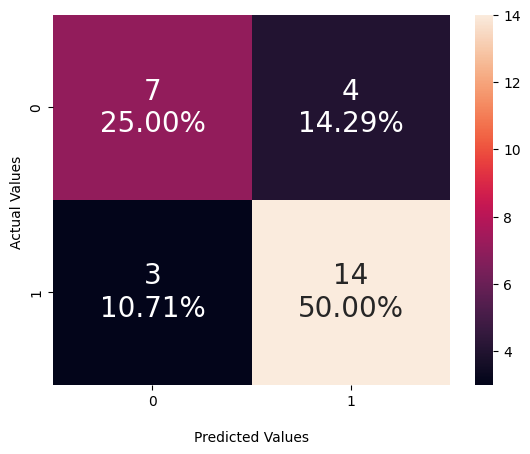



ENSEMBLE - CLIN AND MUT MODELS
F1: 0.7099%
Precision: 0.7762%
Recall: 0.7143%
Accuracy: 0.7143%

AUC: 0.7396%


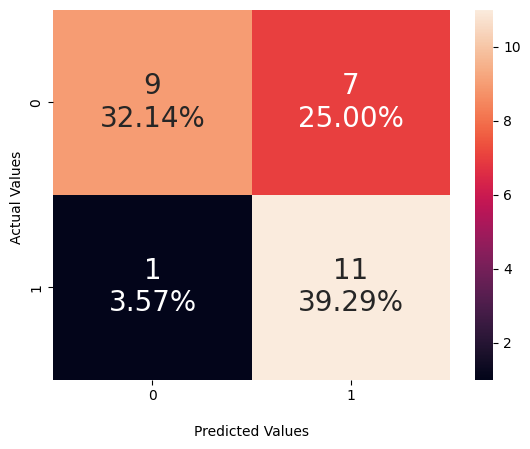

In [ ]:
print("ENSEMBLE - ALL MODELS")

preditions = [list(clin_pred), list(mut_pred), list(clinmut_pred), list(exp_pred), list(clinexp_pred), list(mutexp_pred), list(all_pred)]
preditions = [list(i) for i in zip(*preditions)]

probs = [clin_prob, mut_prob, clinmut_prob, exp_prob, clinexp_prob, mutexp_prob, all_prob]
probs =  np.asarray(probs)
#[list(i) for i in zip(*probs)]

preds = ensembleModelHoldout(preditions, probs, weighted_rank, y_final, 'ALL', useavg=False)

print("\n\nENSEMBLE - CLIN AND MUT MODELS")

preditions = [list(clin_pred), list(mut_pred), list(clinmut_pred)]
preditions = [list(i) for i in zip(*preditions)]

probs = [clin_prob, mut_prob, clinmut_prob]
probs =  np.asarray(probs)

preds = ensembleModelHoldout(preditions, probs, weighted_rank[0:3], y_final, 'CLIN+MUT', useavg=False)


# **Ensemble Leave One Out**

In [ ]:
from sklearn.model_selection import LeaveOneOut

def crossValidationLOO(data, classe_alvo, num_models, models_clf, model_names, title):
    
    ensemble_all_pred = []
    ensemble_clinmut_pred = []
    
    ensemble = []

    f1_result = []
    pres_result = []
    recall_result = []
    roc_result = []
    acc_result = []
    i = 0
    #kf = KFold(n_splits=10, shuffle=False)
    loo = LeaveOneOut()
    
    classes = []
    final_classes = []
    y_test = []
   

    for train_index, test_index in loo.split(data[0]):
        #print(i)

        classes = []
        weights = []
        ensemble_clinmut = []
        ensemble = []
        
        y, y_test = classe_alvo.iloc[train_index], classe_alvo.iloc[test_index]
        
        for i in range(num_models):
        #
            #print(model_names[i])
            X, X_test = data[i].iloc[train_index,:], data[i].iloc[test_index,:]
            
            
            best_model = models_clf[i]
            

            best_model.fit(X, y)
            y_pred = best_model.predict(X_test)
            best_results = checkPerformance(y_pred, y_test, verbose=False)


            ensemble.append(y_pred)

            if model_names[i] in ["CLIN MODEL", "CLIN + MUT MODEL", "MUT MODEL"]:
                ensemble_clinmut.append(y_pred)

            #probs.append(y_prob)
            #weights.append(best_results['F1-Score'][0])

        #i +=1

        classes.append(list(y_test))
        final_classes.append(list(y_test))

        #ensemble tem as predicoes de todos os models
        preditions_all = [list(i) for i in zip(*ensemble)]
        preditions_clinmut = [list(i) for i in zip(*ensemble_clinmut)]
        
        
        #sort = np.argsort(weights)

        #weighted_rank = np.zeros(7)
        #weighted_rank[sort[0:3]] = 0.25
        #weighted_rank[sort[3:6]] = 1.25
        #weighted_rank[sort[6]] = 5

        #weights = weighted_rank
        for i in range(len(preditions_all)):                    
            ensemble_all_pred.append(mode(preditions_all[i]))
        

        #sort = np.argsort(weights[0:3])

        #weighted_rank[sort[0]] = 0.75
        #weighted_rank[sort[1]] = 1.25
        #weighted_rank[sort[2]] = 1.5

        #weights = weighted_rank[0:3]

        for i in range(len(preditions_clinmut)):                    
            ensemble_clinmut_pred.append(mode(preditions_clinmut[i]))
        
        
        

    final_classes = [item for sublist in final_classes for item in sublist]
    
    f1 = metrics.f1_score(ensemble_all_pred, final_classes, average="weighted")
    pres = metrics.precision_score(ensemble_all_pred, final_classes, average="weighted")
    recall = metrics.recall_score(ensemble_all_pred, final_classes, average='weighted')
    acc = metrics.accuracy_score(ensemble_all_pred, final_classes)
    
    try:
        roc = (metrics.roc_auc_score(ensemble_all_pred, final_classes))
    except ValueError:
        roc = 0


    #results = {"model":"LOO", "F1-Score":f1, "Precision":pres, "Recall":recall, "Accuracy": acc, "AUC": roc}
    results = {"model":title, "F1-Score":f1, "AUC": roc,
    "Accuracy": acc, 
    "Precision":pres, 
    "Recall":recall, 
    }



    lines = ["\n\n------- ENSEMBLE ALL -------\n"
    "F1: "+str(f1)+"\n"
    "Precision: "+str(pres)+"\n"
    "Recall: "+str(recall)+"\n"
    "AUC: "+str(roc)+"\n"
    "Accuracy: "+str(acc)+"\n"
    ]
    write_results(lines, "ensemble_loo_results.txt","a")
    print(str(lines[0]))
    conf_matrix(ensemble_all_pred, final_classes)


    f1 = metrics.f1_score(ensemble_clinmut_pred, final_classes, average="weighted")
    pres = metrics.precision_score(ensemble_clinmut_pred, final_classes, average="weighted")
    recall = metrics.recall_score(ensemble_clinmut_pred, final_classes, average='weighted')
    #roc = (roc_auc_score(ensemble_clinmut_pred, final_classes))
    acc = metrics.accuracy_score(ensemble_clinmut_pred, final_classes)

    try:
        roc = (metrics.roc_auc_score(ensemble_clinmut_pred, final_classes))
    except ValueError:
        roc = 0

    #results = {"model":"LOO", "F1-Score":f1, "Precision":pres, "Recall":recall, "Accuracy": acc, "AUC": roc}
    results = {"model":title, "F1-Score":f1, "AUC": roc,
    "Accuracy": acc, 
    "Precision":pres, 
    "Recall":recall, 
    }


    lines = ["\n\n------- ENSEMBLE CLIN MUT -------\n"
    "F1: "+str(f1)+"\n"
    "Precision: "+str(pres)+"\n"
    "Recall: "+str(recall)+"\n"
    "AUC: "+str(roc)+"\n"
    "Accuracy: "+str(acc)+"\n"
    ]
    
    write_results(lines, "ensemble_loo_results.txt","a")
    print(str(lines[0]))
    conf_matrix(ensemble_clinmut_pred, final_classes)
    
    print("done")


    return f1, pres, recall, roc, acc, results





------- ENSEMBLE ALL -------
F1: 0.7216314795419896
Precision: 0.7214338235294119
Recall: 0.7242647058823529
AUC: 0.7069274243187286
Accuracy: 0.7242647058823529



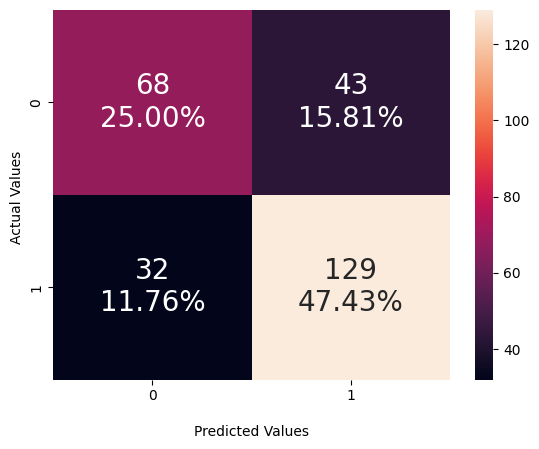



------- ENSEMBLE CLIN MUT -------
F1: 0.6669587996322264
Precision: 0.6844348495212038
Recall: 0.6727941176470589
AUC: 0.671830224384969
Accuracy: 0.6727941176470589



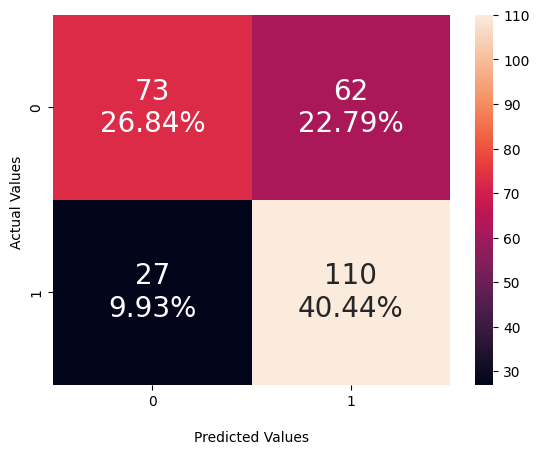

done


In [ ]:
lines = ["Ensemble Model - LOO\n"]
write_results(lines, "ensemble_loo_results.txt","w")

num_models = 7
data_list = [data_clin, data_mut, data_exp, data_clinmut, data_clinexp, data_mutexp, data_all]
models_clf = [best_clin, best_mut, best_exp, best_clinmut, best_clinexp,  best_mutexp, best_all]
model_names = ["CLIN MODEL", "MUT MODEL", "EXP MODEL", "CLIN + MUT MODEL", "CLIN + EXP MODEL", "MUT + EXP MODEL", "ALL BASES MODEL"]

f1, pres, recall, roc, acc, results = crossValidationLOO(data_list, y, num_models, models_clf, model_names, "LOO")
